### **Advanced Portfolio Optimization Topics**

### **Overview**
This notebook delves into advanced portfolio optimization, exploring realistic constraints like **turnover** and **transaction costs**. We also investigate potential use cases enabled by GPU acceleration.

**What You Will Learn**
1.  **Rebalancing Strategy Examples**:
    * **Percent Change Trigger**: Adjusting portfolios based on portfolio value fluctuations.
    * **Drift from Optimal Portfolio**: Managing weight deviations from the optimal allocation.
    * **Maximum Drawdown (MDD)**: Protecting capital by limiting downside risk.
2.  **Incorporating Transaction Costs**:
    * Understanding **why frequent trading can erode returns**.
    * Optimizing portfolio changes **only when the benefits outweigh the costs**.
3.  **Comparing Rebalancing Approaches**:
    * Evaluating **turnover constraints** and their impact on portfolio stability.
    * Using **GPU-accelerated optimization** for high-efficiency computations.

#### **Importing Required Libraries & Initial Setup**

Before diving into portfolio optimization, we need to import the necessary libraries and perform initial setup if required.

In [ ]:
# Install dependencies
# This cell only needs to be run once, typically after setting up the environment.
# If dependencies are already installed, you can comment out or skip this cell.

# Install cuOpt (if not already installed)
#!pip install --upgrade --user --extra-index-url https://pypi.nvidia.com -q cuopt-cu12 

# Install other dependencies (if not already installed)
!pip install --pre --user --extra-index-url https://pypi.nvidia.com -q "numpy>=1.24.4" "pandas>=2.2.1" "cvxpy>=1.6.5" "scipy==1.15.2" "scikit-learn==1.6.1" "msgpack>=1.1.0" "cuml-cu12" "seaborn>=0.13.2" bin/cufolio-25.8-py3-none-any.whl


In [1]:
# Import Required Libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
# Import cuFOLIO and cuOpt
from cufolio import cvar_optimizer, cvar_utils, rebalance
from cuopt import linear_programming
from cuopt.linear_programming.solver_settings import PDLPSolverMode
from cuopt.linear_programming.solver.solver_parameters import *

#### Notebook Setup and Global Configurations

##### Predefined Scenarios
The following dictionary contains predefined market condition scenarios with their respective date ranges. You can select a scenario by its key name in the cells below.

In [2]:
# Predefined Market Scenarios
market_scenarios = {
    'pre_crisis': ('2005-01-01', '2007-10-01'),
    'crisis': ('2007-10-01', '2009-04-01'),
    'post_crisis': ('2009-06-30', '2014-06-30'),
    'oil_price_crash': ('2014-06-01', '2016-03-01'),
    'FAANG_surge': ('2015-01-01', '2021-01-01'),
    'covid': ('2020-01-01', '2023-01-01'),
    'recent_short_sample': ('2021-01-04', '2022-01-01'),       # Used for initial optimization example
    'recent_long_sample': ('2021-01-04', '2024-01-01'),        # Used for turnover optimization example
    'rebalancing_trading_period': ('2021-05-01', '2024-05-01') # Used for rebalancing example
}

# Helper function to get dates from the market_scenarios dictionary
def get_regime_dates(regime_key, scenarios_dict=market_scenarios):
    """
    Retrieves start and end dates for a given regime key from the scenarios dictionary.
    Args:
        regime_key (str): The key for the desired scenario in scenarios_dict.
        scenarios_dict (dict): Dictionary of predefined scenarios.
    Returns:
        tuple: (start_date, end_date)
    Raises:
        ValueError: if regime_key is not found.
    """
    if regime_key in scenarios_dict:
        return scenarios_dict[regime_key]
    else:
        raise ValueError(f"Regime key '{regime_key}' not found in scenarios_dict.")

# --- Global Solver Settings ---
# Initialize GPU solver settings once for the notebook
gpu_solver_settings = linear_programming.SolverSettings()
gpu_solver_settings.set_parameter(CUOPT_PDLP_SOLVER_MODE, PDLPSolverMode.Stable2)
gpu_solver_settings.set_optimality_tolerance(1e-4)              # Define optimality tolerance
gpu_solver_settings.set_parameter(CUOPT_TIME_LIMIT, 10)         # Set time limit for the solver
gpu_solver_settings.set_parameter(CUOPT_LOG_TO_CONSOLE, False)  # Disable log to console

# Package GPU configurations into a dictionary for rebalance module
gpu_solver_configs = {"settings": gpu_solver_settings}

# --- Global Data Settings ---
# Define dataset paths and common parameters
sp500_dataset_name = "sp500"
sp500_dataset_directory = f"../data/stock_data/{sp500_dataset_name}.csv"

global_titans_dataset_name = "global_titans_proxy"
global_titans_dataset_directory = f"../data/stock_data/{global_titans_dataset_name}.csv"

log_return_type = "LOG" # Common return type

#### 1. CVaR Optimization Parameters
This section defines various parameter configurations for Conditional Value-at-Risk (CVaR) optimization. These configurations will be used in subsequent optimization tasks.

**Common CVaR Parameters Explanation:**
-   **Portfolio Constraints:**
    * `w_min`, `w_max`: Minimum and maximum asset weights.
    * `c_min`, `c_max`: Minimum and maximum cash holdings.
    * `L_tar`: Leverage target, representing the total long/short exposure.
-   **Risk Constraints:**
    * `risk_aversion`: Controls the trade-off between return and risk (higher values prioritize lower risk; 0 aims to maximize return subject to risk constraints).
    * `confidence`: Confidence level for CVaR estimation (e.g., 0.95 means we are 95% confident that the worst-case daily loss will not exceed the CVaR).
    * `num_scen`: Number of simulated return scenarios.
-   **Optional Constraints:**
    * `T_tar`: Turnover target, restricting portfolio deviation from an existing allocation (sum of absolute weight changes).
    * `cvar_limit`: Maximum allowed Conditional Value-at-Risk (CVaR).
- **Fitting Method:**
  - `fit_type`: Determines how return distributions are estimated:
    - `'kde'` (Kernel Density Estimation) for non-parametric return modeling.
    - `'gaussian'` Gaussian Distribution Estimation.
    - `'historical'` to use historical return data directly.

In [3]:
# CVaR Parameters for Initial Optimization (Section 2)
initial_opt_cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3,       # Minimum asset weight allocation
    w_max=0.8,        # Maximum asset weight allocation
    c_min=0,          # Minimum cash holdings
    c_max=0,          # Maximum cash holdings
    L_tar=1.6,        # Leverage constraint (total long/short weight change)
    T_tar=None,       # No turnover constraint for initial optimization
    cvar_limit=0.04,  # Maximum allowed Conditional Value-at-Risk (CVaR)
    risk_aversion=1,  # Risk aversion level
    confidence=0.95,  # Confidence level for CVaR calculation
    num_scen=10000,   # Number of return scenarios to simulate
    fit_type="kde"    # Return distribution estimation method
)

# CVaR Parameters for Optimization with Turnover (Section 3)
turnover_opt_cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3,
    w_max=0.8,
    c_min=0.1,        # Note: Different cash constraints
    c_max=0.4,
    L_tar=1.6,
    T_tar=0.5,        # Turnover constraint active
    cvar_limit=0.04,
    risk_aversion=1,
    confidence=0.95,
    num_scen=10000,
    fit_type="kde"
)

# CVaR Parameters for Rebalancing (Sections 4, 5 and part of 6)
# Used for basic rebalancing strategies and the "no turnover constraint" comparison in section 6
rebal_cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3,
    w_max=0.8,
    c_min=0.1,
    c_max=0.4,
    L_tar=1.6,
    T_tar=None,       # No explicit turnover constraint initially for some rebalancing strategies
    cvar_limit=0.02,  # Stricter CVaR risk limit for rebalancing
    risk_aversion=1,
    confidence=0.95,
    num_scen=10000,
    fit_type="kde"
)

# CVaR Parameters for Rebalancing with Transaction Costs & Turnover (Section 6)
rebal_tc_cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3,
    w_max=0.8,
    c_min=0.1,
    c_max=0.4,
    L_tar=1.6,
    T_tar=0.5,        # Turnover constraint for transaction cost rebalancing
    cvar_limit=0.02,
    risk_aversion=1,
    confidence=0.95,
    num_scen=10000,
    fit_type="kde"
)

#### 2. Initial Portfolio Optimization on GPU (No Turnover)
This section demonstrates a basic CVaR portfolio optimization using the S&P 500 dataset for a selected historical period.

##### 2.1. Data Preparation and Problem Instantiation
We select a scenario, calculate returns, and instantiate the CVaR optimization problem.

In [4]:
# --- Select Scenario for Initial Optimization ---
# Choose a key from 'market_scenarios' dictionary (e.g., 'recent_short_sample')
selected_initial_opt_scenario_key = 'recent_short_sample'
initial_opt_start_date, initial_opt_end_date = get_regime_dates(selected_initial_opt_scenario_key)

# Regime dictionary for calculating returns
initial_opt_regime_dict = {"name": selected_initial_opt_scenario_key, "range": (initial_opt_start_date, initial_opt_end_date)}

# Compute returns dictionary
initial_opt_returns_dict = cvar_utils.calculate_returns(
    sp500_dataset_directory,
    initial_opt_regime_dict,
    log_return_type,
    initial_opt_cvar_params # Using parameters defined for initial optimization
)

# Instantiate CVaR optimization problem
initial_cvar_problem = cvar_optimizer.CVaR(
    returns_dict=initial_opt_returns_dict,
    cvar_params=initial_opt_cvar_params,
    problem_from_file=None
)

##### 2.2. Solve the Optimization Problem
The problem is solved using the GPU-accelerated solver.

In [5]:
# Solve the optimization problem using the globally configured GPU solver settings
initial_gpu_result, initial_gpu_portfolio = initial_cvar_problem.solve_optimization_problem(
    device="GPU",
    gpu_settings=gpu_solver_settings # Using global solver settings
)
# The results (initial_gpu_result, initial_gpu_portfolio) will be printed by the solve_optimization_problem method.
# initial_gpu_portfolio will be used as the 'existing_portfolio' in the next section.

*************************
--- GPU CVaR Results---
recent_short_sample: ('2021-01-04', '2022-01-01')
Scenarios: 10000
solver time: 0.4320 seconds
IO time: 0.2438 seconds
--- Optimal Portfolio ---
Long--AZO: 0.088
Long--CPT: 0.044
Long--DVN: 0.173
Long--EXR: 0.393
Long--F: 0.149
Short--GPN: -0.148
Long--IRM: 0.008
Long--IT: 0.14
Short--LVS: -0.09
Long--NVDA: 0.036
Long--ON: 0.034
Long--PFE: 0.16
Long--PSA: 0.028
Short--ROL: -0.024
Long--STX: 0.013
Long--TECH: 0.034
Short--TFX: -0.038
cash: 0.0
*************************



#### 3. CVaR Optimization with Turnover Limit
This section introduces an existing portfolio and optimizes a new portfolio with a turnover constraint, limiting its deviation from the existing one. The mathematical formulation is:

$$
\begin{align*}
\text{Minimize: } & \mathbf{\mu}^T \mathbf{w} - \lambda\left(t + \frac{1}{1-\alpha} \mathbf{p}^T \mathbf{u}\right)\\\
\text{Subject to: }
& \mathbf{u} + t \geq -\mathbf{R}^T \mathbf{w},\\
& \mathbf{u} \geq \mathbf{0},\\
& \mathbf{1}^T \mathbf{w} + c = 1, \quad \mathbf{w}^{\min} \leq \mathbf{w} \leq \mathbf{w}^{\max}, \quad c^{\min} \leq c \leq c^{\max},\\
&L := \lVert \mathbf{w} \rVert_1 \leq L^{limit},\\
&T := \lVert \mathbf{w} - \mathbf{w}_{pre}\rVert_1 \leq T^{limit}.
\end{align*}
$$

##### 3.1. Data Preparation for Turnover Optimization
We use a different (potentially longer) sample period for this optimization.

In [6]:
# --- Select Scenario for Turnover Optimization ---
selected_turnover_opt_scenario_key = 'recent_long_sample'
turnover_opt_start_date, turnover_opt_end_date = get_regime_dates(selected_turnover_opt_scenario_key)

# Regime dictionary for calculating returns
turnover_opt_regime_dict = {"name": selected_turnover_opt_scenario_key, "range": (turnover_opt_start_date, turnover_opt_end_date)}

# Compute returns dictionary
turnover_opt_returns_dict = cvar_utils.calculate_returns(
    sp500_dataset_directory,
    turnover_opt_regime_dict,
    log_return_type,
    turnover_opt_cvar_params # Using parameters defined for turnover optimization
)

# Existing portfolio (from previous optimization in section 2.2)
# Ensure 'initial_gpu_portfolio' from the previous step is available
if 'initial_gpu_portfolio' not in globals():
    raise NameError("Variable 'initial_gpu_portfolio' is not defined. Please run the previous optimization cell (2.2).")
existing_portfolio_for_turnover = initial_gpu_portfolio

##### 3.2. Initialize and Solve CVaR Optimization with Existing Portfolio
We create a CVaR optimizer object incorporating the existing portfolio and turnover constraints.

In [7]:
# Initialize CVaR optimization with turnover constraints
turnover_constrained_cvar_problem = cvar_optimizer.CVaR(
    returns_dict=turnover_opt_returns_dict,
    cvar_params=turnover_opt_cvar_params,
    problem_from_file=None,
    existing_portfolio=existing_portfolio_for_turnover
)

# Solve the CVaR optimization problem with turnover constraints
turnover_constrained_result, turnover_constrained_portfolio = turnover_constrained_cvar_problem.solve_optimization_problem(
    device="GPU",
    gpu_settings=gpu_solver_settings # Using global solver settings
)

*************************
--- GPU CVaR Results---
recent_long_sample: ('2021-01-04', '2024-01-01')
Scenarios: 10000
solver time: 0.3410 seconds
IO time: 0.1856 seconds
--- Optimal Portfolio ---
Long--AZO: 0.088
Long--CPT: 0.044
Long--DVN: 0.173
Long--EXR: 0.257
Long--F: 0.142
Short--GPN: -0.148
Short--ILMN: -0.027
Long--IRM: 0.008
Long--IT: 0.14
Long--LLY: 0.05
Short--LVS: -0.09
Short--MTCH: -0.173
Long--NVDA: 0.036
Long--ON: 0.034
Long--PFE: 0.054
Long--PSA: 0.028
Short--ROL: -0.024
Long--STX: 0.013
Long--TECH: 0.034
Short--TFX: -0.038
cash: 0.4
*************************



##### 3.3. Checking if Turnover Constraint is Met
This section verifies that the turnover constraint is respected by comparing the sum of absolute weight changes against the predefined turnover limit (`T_tar`).

In [8]:
# Check if the turnover constraint is met
# Ensure 'turnover_opt_cvar_params' and portfolios are available
turnover_error = turnover_opt_cvar_params.T_tar - np.sum(np.abs(turnover_constrained_portfolio.weights - existing_portfolio_for_turnover.weights))

# Print the error value (should be close to zero or positive if the constraint is satisfied)
print(f"Turnover constraint check (T_tar - actual_turnover): {turnover_error}")
if turnover_error < -1e-2: # Allowing for small numerical inaccuracies
    print("Warning: Turnover constraint may not be strictly met.")
else:
    print("Turnover constraint is satisfied.")

Turnover constraint check (T_tar - actual_turnover): -0.0003862113868058348
Turnover constraint is satisfied.


#### 4. Portfolio Rebalancing Strategies: Setup
Portfolio rebalancing is crucial for aligning a portfolio with its target risk-return profile. GPU acceleration allows for efficient backtesting of these strategies over extended periods. This section sets up the parameters for various rebalancing tests.

##### 4.1. Rebalancing Period and Window Configuration
We define the trading horizon and look-back/look-forward windows for backtesting using the "global_titans_proxy" dataset.

In [9]:
# --- Select Scenario for Rebalancing ---
selected_rebal_scenario_key = 'rebalancing_trading_period'
rebal_trading_start_date, rebal_trading_end_date = get_regime_dates(selected_rebal_scenario_key)

# Look-back and look-forward windows for backtesting
rebal_look_back_window = 126        # Historical period used for optimization (days)
rebal_look_forward_window = 63      # Testing period (out-of-sample performance)

# CVaR parameters for these rebalancing strategies will use 'rebal_cvar_params'
# GPU solver configurations are already globally defined in 'gpu_solver_configs'

#### 5. Portfolio Rebalancing Strategy Implementations
We explore three rebalancing strategies:
1.  **Percent Change of Portfolio Value**: Triggers rebalancing if portfolio value declines beyond a threshold.
2.  **Drift from Optimal Portfolio**: Adjusts holdings if asset weights deviate significantly.
3.  **Maximum Drawdown (MDD)**: Rebalances if peak-to-trough decline exceeds a limit.

##### 5.1. Strategy 1: Re-Optimizing Based on Percent Change
Rebalancing is triggered if:
-   The percent change in portfolio value over a testing period falls below `pct_change_tolerance`.
-   The cumulative percent change since the **last positive** percent change period falls below `pct_change_tolerance`.

*****Testing No Re-Optimize*****
*****Testing Re-Optimize*****


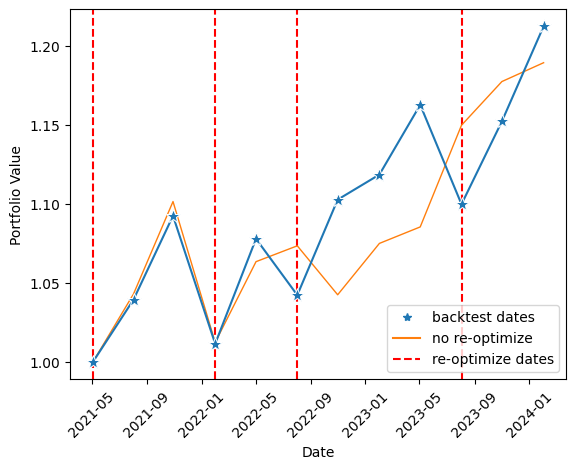

In [10]:
# Define re-optimization tolerance threshold for percent change
pct_change_rebal_tolerance = -0.005   # Trigger if portfolio value drops by more than 0.5%

# Set re-optimization criteria
pct_change_re_optimize_criteria = {"type": "pct_change", "threshold": pct_change_rebal_tolerance}

# Execute portfolio rebalancing
pct_change_rebalancing_obj = rebalance.rebalance_portfolio(
    dataset_directory=global_titans_dataset_directory,
    trading_start=rebal_trading_start_date,
    trading_end=rebal_trading_end_date,
    look_forward_window=rebal_look_forward_window,
    look_back_window=rebal_look_back_window,
    cvar_params=rebal_cvar_params,          # Using general rebalancing CVaR params
    gpu_configs=gpu_solver_configs,         # Using global GPU configs
    re_optimize_criteria=pct_change_re_optimize_criteria,
    return_type=log_return_type,
    print_opt_result=False
)

# Retrieve and plot optimization results
pct_change_results_df, pct_change_re_optimize_dates = pct_change_rebalancing_obj.re_optimize(plot_results=True)

##### 5.2. Strategy 2: Drift from Optimal Portfolio
Re-optimizes if the norm of the difference between current and optimal weights exceeds `drift_tolerance`.
$$ \| w_{cur} - w_{opt} \| > tol $$
Where:
-   $ w_{cur} $ = Current portfolio weights
-   $ w_{opt} $ = Optimal portfolio weights
-   $ tol $ = **Drift tolerance**
-   **Norm type**: 1-norm (absolute differences) or 2-norm (Euclidean distance).

*****Testing No Re-Optimize*****
*****Testing Re-Optimize*****


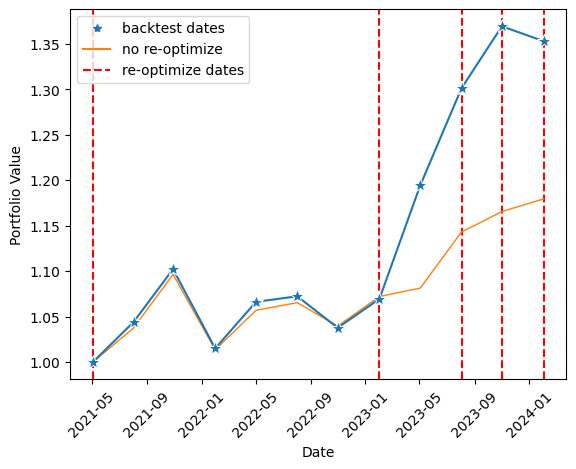

In [11]:
# Define drift tolerance threshold
drift_rebal_tolerance = 0.01        # Rebalance if weight deviation (L2 norm) exceeds 1%

# Set re-optimization criteria for drift
drift_re_optimize_criteria = {
    "type": "drift_from_optimal",
    "threshold": drift_rebal_tolerance,
    "norm": 2,                # Using L2 norm
}

# Execute portfolio rebalancing
drift_rebalancing_obj = rebalance.rebalance_portfolio(
    dataset_directory=global_titans_dataset_directory,
    trading_start=rebal_trading_start_date,
    trading_end=rebal_trading_end_date,
    look_forward_window=rebal_look_forward_window,
    look_back_window=rebal_look_back_window,
    cvar_params=rebal_cvar_params,
    gpu_configs=gpu_solver_configs,
    re_optimize_criteria=drift_re_optimize_criteria,
    return_type=log_return_type,
    print_opt_result=False
)

# Retrieve and plot results
drift_results_df, drift_re_optimize_dates = drift_rebalancing_obj.re_optimize(plot_results=True)

##### 5.3. Strategy 3: Maximum Drawdown (MDD)
Re-optimizes if the max drawdown over a backtest period exceeds `max_drawdown_tolerance`.
$$ \text{Max Drawdown} = \frac{\text{Peak} - \text{Trough}}{\text{Peak}} $$

*****Testing No Re-Optimize*****
*****Testing Re-Optimize*****


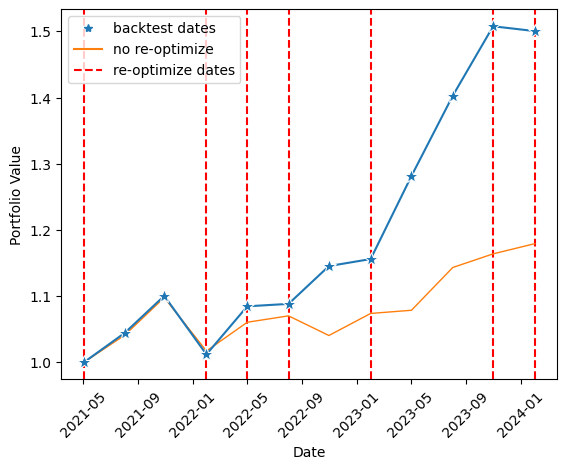

In [12]:
# Define max drawdown tolerance threshold
mdd_rebal_tolerance = 0.05      # Rebalance if portfolio drops more than 5% from peak

# Set re-optimization criteria for max drawdown
mdd_re_optimize_criteria = {"type": "max_drawdown", "threshold": mdd_rebal_tolerance}

# Execute portfolio rebalancing
mdd_rebalancing_obj = rebalance.rebalance_portfolio(
    dataset_directory=global_titans_dataset_directory,
    trading_start=rebal_trading_start_date,
    trading_end=rebal_trading_end_date,
    look_forward_window=rebal_look_forward_window,
    look_back_window=rebal_look_back_window,
    cvar_params=rebal_cvar_params,
    gpu_configs=gpu_solver_configs,
    re_optimize_criteria=mdd_re_optimize_criteria,
    return_type=log_return_type,
    print_opt_result=False
)

# Retrieve and plot results
mdd_results_df, mdd_re_optimize_dates = mdd_rebalancing_obj.re_optimize(plot_results=True)

#### 6. Rebalancing Portfolio with Transaction Costs
This section implements drift-based rebalancing while accounting for transaction costs. We first run a rebalancing strategy that incorporates turnover constraints (and thus considers transaction costs implicitly by limiting trades). Then, we compare it against a model without turnover constraints to evaluate the impact.

##### 6.1. Rebalancing with Turnover Constraints (Implicit Transaction Cost Consideration)
This strategy uses `rebal_tc_cvar_params` which includes a `T_tar` (turnover target).

*****Testing No Re-Optimize*****
No existing portfolio: no turnover constraint imposed.
*****Testing Re-Optimize*****
No existing portfolio: no turnover constraint imposed.


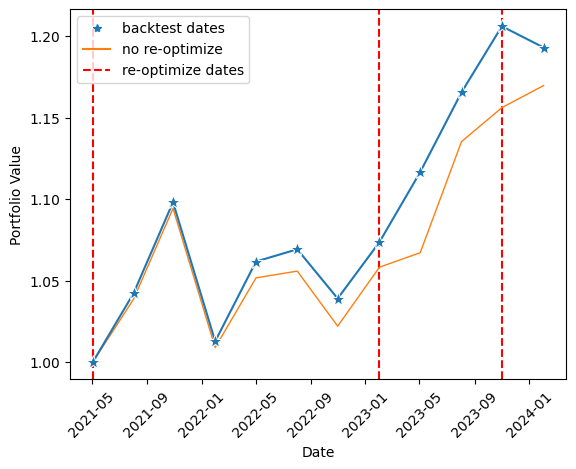

In [13]:
# Rebalancing criteria (drift-based)
tc_drift_rebal_tolerance = 0.01
tc_re_optimize_criteria = {
    "type": "drift_from_optimal",
    "threshold": tc_drift_rebal_tolerance,
    "norm": 2
}

# Transaction cost factor for performance evaluation (does not affect optimization directly here, but used in plotting)
transaction_cost_factor_eval = 0.001   # Cost per trade for evaluation

# Perform rebalancing WITH turnover constraint
tc_drift_rebalancing_obj = rebalance.rebalance_portfolio(
    dataset_directory=global_titans_dataset_directory,
    trading_start=rebal_trading_start_date,
    trading_end=rebal_trading_end_date,
    look_forward_window=rebal_look_forward_window,
    look_back_window=rebal_look_back_window,
    cvar_params=rebal_tc_cvar_params,   # CVaR params WITH turnover
    gpu_configs=gpu_solver_configs,
    re_optimize_criteria=tc_re_optimize_criteria,
    return_type=log_return_type,
    print_opt_result=False
)

# Retrieve and plot results, including transaction cost impact on performance
tc_drift_results_df, tc_drift_re_optimize_dates = tc_drift_rebalancing_obj.re_optimize(
    plot_results=True,
    transaction_cost_factor=transaction_cost_factor_eval
)

##### 6.2. Comparison: Rebalancing WITHOUT Turnover Constraint
To evaluate the impact, we run the same drift-based rebalancing but using `rebal_cvar_params` (which has `T_tar=None`).

*****Testing No Re-Optimize*****
*****Testing Re-Optimize*****


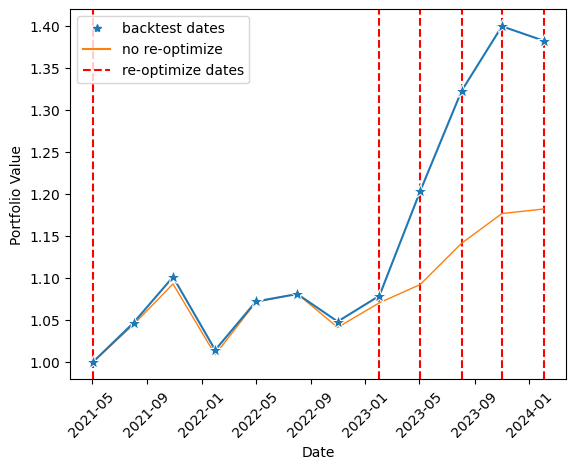

In [14]:
# Perform rebalancing WITHOUT turnover constraint for comparison
# Criteria remain drift-based, identical to 6.1
no_tc_drift_rebalancing_obj = rebalance.rebalance_portfolio(
    dataset_directory=global_titans_dataset_directory,
    trading_start=rebal_trading_start_date,
    trading_end=rebal_trading_end_date,
    look_forward_window=rebal_look_forward_window,
    look_back_window=rebal_look_back_window,
    cvar_params=rebal_cvar_params,                # CVaR params WITHOUT turnover (same as rebal_cvar_params)
    gpu_configs=gpu_solver_configs,
    re_optimize_criteria=tc_re_optimize_criteria, # Using the same drift criteria for fair comparison
    return_type=log_return_type,
    print_opt_result=False
)

# Retrieve and plot results, including transaction cost impact on performance
no_tc_drift_results_df, no_tc_drift_re_optimize_dates = no_tc_drift_rebalancing_obj.re_optimize(
    plot_results=True,
    transaction_cost_factor=transaction_cost_factor_eval
)

---
SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
SPDX-License-Identifier: MIT
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.